In [1]:
from scipy.io.wavfile import read, write
import torchaudio
import torch
from librosa.util import normalize
from librosa.filters import mel as librosa_mel_fn
import numpy as np
import librosa
from IPython.display import Audio
from tqdm import tqdm
import os
import soundfile as sf
import json

In [2]:
MAX_WAV_VALUE = 32768.0

def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)

def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

In [3]:
ac_train_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/ac_train.json"
ac_val_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/ac_val.json"
audioset_sl_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/audioset_sl.json"
bbc_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/bbc.json"
soundbible_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/soundbible.json"
fsd_10s_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/fsd_10s.json"

with open(ac_train_json, "r") as f:
    ac_train_infos = json.load(f)
with open(ac_val_json, "r") as f:
    ac_val_infos = json.load(f)
with open(audioset_sl_json, "r") as f:
    audioset_sl_infos = json.load(f)
with open(bbc_json, "r") as f:
    bbc_infos = json.load(f)
with open(bbc_json, "r") as f:
    soundbible_infos = json.load(f)
with open(bbc_json, "r") as f:
    fsd_10s_infos = json.load(f)
print(len(ac_train_infos), len(ac_val_infos), len(audioset_sl_infos),
      len(bbc_infos), len(soundbible_infos), len(fsd_10s_infos))

45435 449 79147 11754 11754 11754


In [4]:
six_sets_infos = bbc_infos + soundbible_infos + fsd_10s_infos + audioset_sl_infos + ac_train_infos + ac_val_infos
a_infos = []
for info in tqdm(six_sets_infos[:]):
    if len(info["caption"].split(" ")) <= 8:
        a_infos.append(info)
print(len(a_infos))
a_infos[:10]

100%|██████████| 160293/160293 [00:00<00:00, 1103810.24it/s]

76815


[{'mel': '/blob/v-yuancwang/WavCaps/BBC/mel/07043127.npy',
  'caption': 'A car is passing by.'},
 {'mel': '/blob/v-yuancwang/WavCaps/BBC/mel/07044066.npy',
  'caption': 'A bicycle is approaching and skidding.'},
 {'mel': '/blob/v-yuancwang/WavCaps/BBC/mel/07043344.npy',
  'caption': 'A torpedo is passing from left to right.'},
 {'mel': '/blob/v-yuancwang/WavCaps/BBC/mel/NHU05061045.npy',
  'caption': 'A bird is calling while perched.'},
 {'mel': '/blob/v-yuancwang/WavCaps/BBC/mel/07043241.npy',
  'caption': 'A rapid cyclical alarm is sounding.'},
 {'mel': '/blob/v-yuancwang/WavCaps/BBC/mel/07057085.npy',
  'caption': 'Applause is heard.'},
 {'mel': '/blob/v-yuancwang/WavCaps/BBC/mel/07001019.npy',
  'caption': 'A carving knife is being sharpened on steel.'},
 {'mel': '/blob/v-yuancwang/WavCaps/BBC/mel/07032304.npy',
  'caption': 'An express train is arriving.'},
 {'mel': '/blob/v-yuancwang/WavCaps/BBC/mel/07002279.npy',
  'caption': 'A tractor is passing by.'},
 {'mel': '/blob/v-yuancw

In [ ]:
# fsd2s_json_file = "/home/v-yuancwang/AUDIT_v2/medata_infos/fsd_2s.json"
# fsd50k_2s_json_file = "/home/v-yuancwang/AUDIT_v2/medata_infos/fsd50k_2s.json"
# fsd5s_json_file = "/home/v-yuancwang/AUDIT_v2/medata_infos/fsd_5s.json"
# fsd50k_5s_json_file = "/home/v-yuancwang/AUDIT_v2/medata_infos/fsd50k_5s.json"
# with open(fsd2s_json_file, "r") as f:
#     fsd2s_infos = json.load(f)
# with open(fsd5s_json_file, "r") as f:
#     fsd5s_infos = json.load(f)
# with open(fsd50k_2s_json_file, "r") as f:
#     fsd50k_2s_infos = json.load(f)
# with open(fsd50k_5s_json_file, "r") as f:
#     fsd50k_5s_infos = json.load(f)
# print(len(fsd2s_infos), len(fsd5s_infos), len(fsd50k_2s_infos), len(fsd50k_5s_infos))

In [ ]:
# b_infos = fsd2s_infos + fsd5s_infos + fsd50k_2s_infos + fsd50k_5s_infos
# len(b_infos)

In [ ]:
# b_before_a_templates = ["\{B\}, then \{A\}", "\{B\}, then, \{A\}", "\{A\} come after \{B\}", "\{B\} followed by \{A\}",
#              "\{B\} took place before \{A\}", "\{B\}, and then \{A\}", "\{B\}, after that \{A\}", "\{B\}, before \{A\}"]

In [5]:
a_add_b_templates = ["\{A\}, while \{B\}", "\{A\}, and \{B\}", "\{A\}, at the same time, \{B\}",
                     "\{A\} while \{A\}", "\{A\} mixed with \{B\}", "\{A\}, \{B\}"]

In [6]:
# add_wav_path = "/blob/v-yuancwang/WavCaps/Add/wav"
# add_mel_path = "/blob/v-yuancwang/WavCaps/Add/mel"
add_wav_path = "/blob/v-yuancwang/WavCaps/Add_Bg/wav"
add_mel_path = "/blob/v-yuancwang/WavCaps/Add_Bg/mel"

In [14]:
json_lists = []
for i in tqdm(range(20000)[:]):
    a_id, b_id = 0, 0
    while (a_id == b_id):
        a_id = np.random.randint(0, len(a_infos))
        b_id = np.random.randint(0, len(a_infos))
    a_wav_path, a_caption = a_infos[a_id]["mel"].replace("/mel/", "/wav/").replace(".npy", ".wav"), a_infos[a_id]["caption"]
    b_wav_path, b_caption = a_infos[b_id]["mel"].replace("/mel/", "/wav/").replace(".npy", ".wav"), a_infos[b_id]["caption"]
    template = np.random.choice(a_add_b_templates)
    caption = template.replace("\{A\}", a_caption.lower().replace(".", "")).replace("\{B\}", b_caption.lower().replace(".", ""))
    # print(caption)
    a_mel, b_mel = np.load(a_infos[a_id]["mel"]), np.load(a_infos[b_id]["mel"])
    a_wav, sr = librosa.load(a_wav_path, sr=16000)
    b_wav, sr = librosa.load(b_wav_path, sr=16000)

    a_wav = np.pad(a_wav, (0, max(0, 16000*10-len(a_wav))), 'constant', constant_values=(0,0))[:16000*10]
    b_wav = np.pad(b_wav, (0, max(0, 16000*10-len(b_wav))), 'constant', constant_values=(0,0))[:16000*10]
    c_wav = a_wav + b_wav
    
    c_wav = np.clip(c_wav, -1, 1)
    x = torch.FloatTensor(c_wav)
    x = mel_spectrogram(x.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
                        hop_size=256, win_size=1024, fmin=0, fmax=8000)
    spec = x.cpu().numpy()[0]
    # print(spec.shape)

    c_wav = c_wav * MAX_WAV_VALUE
    c_wav = c_wav.astype('int16')
    write(os.path.join(add_wav_path, "add_{}".format(str(i))+".wav"), 16000, c_wav)
    np.save(os.path.join(add_mel_path, "add_{}".format(str(i))+".npy"), spec)
    json_lists.append({"mel": os.path.join(add_mel_path, "add_{}".format(str(i))+".npy"),
                       "caption": caption})
    
with open("/home/v-yuancwang/AUDIT_v2/medata_infos/add_a_b.json", "w") as f:
    json.dump(json_lists, f)

100%|██████████| 20000/20000 [39:23<00:00,  8.46it/s]  


In [9]:
import matplotlib.pyplot as plt

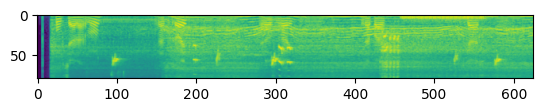

In [10]:
plt.imshow(np.load("/blob/v-yuancwang/WavCaps/Add_Bg/mel/add_2.npy"))